<a href="https://colab.research.google.com/github/deepakgahlot98/AndroidDatabases/blob/master/notebook29ff348b42_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
<br>
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 <br>

Each video is a sequence of 30 frames (or images)

In [ ]:
# import relevant libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import abc
from glob import glob
import pathlib
import PIL

In [ ]:
# libraries for model building

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from keras.layers import Dropout

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

We need to change the batch_size and other parameters which needs to be changed to try different models. Hence, to keep the code clean, let's adopt object oriented approach as per below image.

#### Class ModelProducer
    - initialize the object with training file, validation file, training folder and validation folder.
    - initialize_image_properties : height, width , channels and frames. This is used to try different cropping sizes.
    - initialize_hyperparams : This is used to set the hyper parameter [frames to sample, batch size , epochs] and try different models.
    - generator : It is used to generate batch of data.
    - get_one_batch_data : It is used to get one batch of data. It is used within generator function. 
    - train_model : It is used to train the compiled model , initialize callbacks and save the model as per callback condition.
    - define_model : This is an abstract method which can be overloaded by other classes which will define model of various kinds such as different depths, with and without dropouts, Convolution 3D, CNN-RNN etc.

<font color='red'> image to be included for classess and method names. </font>

## Generator



In [ ]:
class ModelProducer():
    
    def __init__(self,train_file,val_file,train_folder,val_folder,no_of_classes):
        '''
        train_file : path to the training file along with filename.
        val_file : path to the validation file along with filename.
        train_folder : path to training videos / frames
        val_folder : patht to validation videos / frames
        '''
        self.train_doc = np.random.permutation(open(train_file).readlines())
        self.val_doc = np.random.permutation(open(val_file).readlines())
        self.train_path = train_folder
        self.val_path =  val_folder
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.num_classes=no_of_classes
        
        
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100,no_of_channels=3,no_of_frames=30):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=no_of_channels
        self.total_frames=no_of_frames
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # The generator function 
    
    def generator(self,source_path, folder_list,augment=False):
        
        # We will try frames_to_sample in order to check the execution time and accuracy.
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        
        
        batch_size=self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
            
            # Check if any data points are pending to be processed.
            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    # Create a function to get one batch of data.
    def get_one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    # Crearte abstract method to be overloaded by child class to define the model.
    @abc.abstractmethod
    def define_model(self):
        pass

We need to define two types of models:
- Convolution 3D
- CNN - RNN 

We will try various models by overloading define_model method of the ModelProducer class.

In [ ]:
class ModelConv3D1(ModelProducer):
    
    def define_model(self,optimiser = 'adam',loss='categorical_crossentropy'):
        # Model = Sequential --> Conv3D(16) --> BatchNorm --> MaxPooling3D --> Conv3D(32) --> BatchNorm --> MaxPooling3D
        #            --> Conv3D(64) --> BatchNorm --> MaxPooling3D --> Conv3D(128) --> BatchNorm --> MaxPooling3D
        #            --> Flatten --> Dense(128) --> Dropout(0.5) --> Dense(64) --> Dropout(0.25) --> Dense(num_classes)

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        model.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])
        return model

In [ ]:
# function to plot the model accuracy

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for google colab
# from google.colab import drive
# import os

# drive.mount('/content/gdrive')
root_path = '/content/drive/MyDrive/Project_data'
# os.chdir(root_path)
# !ls -lrt

Read the folder names for training and validation. 



In [ ]:
train_file = root_path + '/train.csv'
val_file = root_path + '/val.csv'
train_folder = root_path + '/train/'
val_folder = root_path + '/val/'

# No of classes in our problem statement is 5
no_of_classes = 5

In [ ]:

#train_file,val_file,train_folder,val_folder,no_of_classes

conv_3d1=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
#conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

Let's check if the considered height and width can be recognized by the model. If human can recognize it then model should also recognize the same.

We have used 160 by 160 as default height and width in the class, hence, let's verify the same.

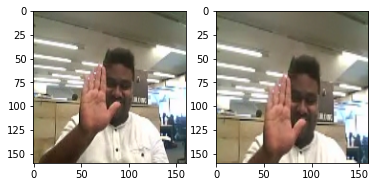

In [ ]:
test_generator=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])

# as the batch size is 3, 4th index will be augmented image.
axes[1].imshow(batch_data[3,15,:,:,:]) 

It can be seen that both images are giving same information. Hence, image resizing is working fine and it can be used in the model.

In [ ]:
conv_3d1.train_model(conv_3d1_model)

The model took lot of time to execute with 160 by 160 image size and 30 frames. Let's try different options to arrive at optimum image size, batch_size and epochs.

In [76]:
conv_3d1=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
#conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5088 - categorical_accuracy: 0.4419
Epoch 00001: val_loss improved from inf to 1.61629, saving model to model_init_2021-12-2815_21_18.156439/model-00001-1.50878-0.44193-1.61629-0.38000.h5
23/23 [==============================] - 92s 4s/step - loss: 1.5088 - categorical_accuracy: 0.4419 - val_loss: 1.6163 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1060 - categorical_accuracy: 0.5988
Epoch 00002: val_loss did not improve from 1.61629
23/23 [==============================] - 89s 4s/step - loss: 1.1060 - categorical_accuracy: 0.5988 - val_loss: 2.2722 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [77]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.6081 - categorical_accuracy: 0.4027 
Epoch 00001: val_loss improved from inf to 1.55686, saving model to model_init_2021-12-2815_24_23.077365/model-00001-1.60805-0.40271-1.55686-0.25000.h5
34/34 [==============================] - 1598s 48s/step - loss: 1.6081 - categorical_accuracy: 0.4027 - val_loss: 1.5569 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.1957 - categorical_accuracy: 0.5173
Epoch 00002: val_loss did not improve from 1.55686
34/34 [==============================] - 165s 5s/step - loss: 1.1957 - categorical_accuracy: 0.5173 - val_loss: 3.2312 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [78]:
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6809 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 3.37083, saving model to model_init_2021-12-2815_54_31.434911/model-00001-1.68086-0.40271-3.37083-0.19000.h5
45/45 [==============================] - 186s 4s/step - loss: 1.6809 - categorical_accuracy: 0.4027 - val_loss: 3.3708 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1718 - categorical_accuracy: 0.5370
Epoch 00002: val_loss improved from 3.37083 to 2.82179, saving model to model_init_2021-12-2815_54_31.434911/model-00002-1.17177-0.53695-2.82179-0.27000.h5
45/45 [==============================] - 184s 4s/step - loss: 1.1718 - categorical_accuracy: 0.5370 - val_loss: 2.8218 - val_categorical_accuracy: 0.2700 - lr: 0.0010


In [79]:
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5701 - categorical_accuracy: 0.4314
Epoch 00001: val_loss improved from inf to 2.96392, saving model to model_init_2021-12-2816_00_45.563894/model-00001-1.57010-0.43137-2.96392-0.16000.h5
23/23 [==============================] - 102s 5s/step - loss: 1.5701 - categorical_accuracy: 0.4314 - val_loss: 2.9639 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0269 - categorical_accuracy: 0.6214
Epoch 00002: val_loss did not improve from 2.96392
23/23 [==============================] - 101s 5s/step - loss: 1.0269 - categorical_accuracy: 0.6214 - val_loss: 2.9857 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [80]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.8952 - categorical_accuracy: 0.3409 
Epoch 00001: val_loss improved from inf to 1.49830, saving model to model_init_2021-12-2816_04_12.473514/model-00001-1.89523-0.34087-1.49830-0.32000.h5
12/12 [==============================] - 172s 15s/step - loss: 1.8952 - categorical_accuracy: 0.3409 - val_loss: 1.4983 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.2119 - categorical_accuracy: 0.5415 
Epoch 00002: val_loss did not improve from 1.49830
12/12 [==============================] - 163s 15s/step - loss: 1.2119 - categorical_accuracy: 0.5415 - val_loss: 1.6447 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [81]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.7568 - categorical_accuracy: 0.3665
Epoch 00001: val_loss improved from inf to 1.73842, saving model to model_init_2021-12-2816_10_00.222934/model-00001-1.75678-0.36652-1.73842-0.23000.h5
12/12 [==============================] - 92s 8s/step - loss: 1.7568 - categorical_accuracy: 0.3665 - val_loss: 1.7384 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 6s - loss: 1.1734 - categorical_accuracy: 0.5470 
Epoch 00002: val_loss improved from 1.73842 to 1.55817, saving model to model_init_2021-12-2816_10_00.222934/model-00002-1.17726-0.54600-1.55817-0.22000.h5
12/12 [==============================] - 88s 8s/step - loss: 1.1773 - categorical_accuracy: 0.5460 - val_loss: 1.5582 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [82]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7005 - categorical_accuracy: 0.3876
Epoch 00001: val_loss improved from inf to 1.64266, saving model to model_init_2021-12-2816_13_07.735063/model-00001-1.70052-0.38763-1.64266-0.23000.h5
9/9 [==============================] - 94s 11s/step - loss: 1.7005 - categorical_accuracy: 0.3876 - val_loss: 1.6427 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.0692 - categorical_accuracy: 0.5973
Epoch 00002: val_loss improved from 1.64266 to 1.55879, saving model to model_init_2021-12-2816_13_07.735063/model-00002-1.06918-0.59729-1.55879-0.26000.h5
9/9 [==============================] - 83s 10s/step - loss: 1.0692 - categorical_accuracy: 0.5973 - val_loss: 1.5588 - val_categorical_accuracy: 0.2600 - lr: 0.0010


In [83]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.6649 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 1.68288, saving model to model_init_2021-12-2816_16_14.595129/model-00001-1.66485-0.40271-1.68288-0.25000.h5
17/17 [==============================] - 91s 6s/step - loss: 1.6649 - categorical_accuracy: 0.4027 - val_loss: 1.6829 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.1089 - categorical_accuracy: 0.5701
Epoch 00002: val_loss did not improve from 1.68288
17/17 [==============================] - 89s 6s/step - loss: 1.1089 - categorical_accuracy: 0.5701 - val_loss: 2.4059 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [84]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.7979 - categorical_accuracy: 0.3333
Epoch 00001: val_loss improved from inf to 2.17004, saving model to model_init_2021-12-2816_19_20.236398/model-00001-1.79787-0.33333-2.17004-0.16000.h5
45/45 [==============================] - 91s 2s/step - loss: 1.7979 - categorical_accuracy: 0.3333 - val_loss: 2.1700 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2613 - categorical_accuracy: 0.5083
Epoch 00002: val_loss did not improve from 2.17004
45/45 [==============================] - 88s 2s/step - loss: 1.2613 - categorical_accuracy: 0.5083 - val_loss: 2.2669 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [85]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.4208
Epoch 00001: val_loss improved from inf to 3.16508, saving model to model_init_2021-12-2816_22_20.281030/model-00001-1.61018-0.42081-3.16508-0.16000.h5
67/67 [==============================] - 90s 1s/step - loss: 1.6102 - categorical_accuracy: 0.4208 - val_loss: 3.1651 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2872 - categorical_accuracy: 0.5023
Epoch 00002: val_loss did not improve from 3.16508
67/67 [==============================] - 91s 1s/step - loss: 1.2872 - categorical_accuracy: 0.5023 - val_loss: 3.6732 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [86]:
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.3967
Epoch 00001: val_loss improved from inf to 3.90956, saving model to model_init_2021-12-2816_25_22.400239/model-00001-1.61082-0.39668-3.90956-0.25000.h5
67/67 [==============================] - 167s 3s/step - loss: 1.6108 - categorical_accuracy: 0.3967 - val_loss: 3.9096 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1686 - categorical_accuracy: 0.5370
Epoch 00002: val_loss did not improve from 3.90956
67/67 [==============================] - 165s 3s/step - loss: 1.1686 - categorical_accuracy: 0.5370 - val_loss: 5.2730 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [87]:
conv_3d1=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5685 - categorical_accuracy: 0.4042
Epoch 00001: val_loss improved from inf to 1.64423, saving model to model_init_2021-12-2816_30_57.337783/model-00001-1.56845-0.40422-1.64423-0.22000.h5
17/17 [==============================] - 104s 6s/step - loss: 1.5685 - categorical_accuracy: 0.4042 - val_loss: 1.6442 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.0213 - categorical_accuracy: 0.6139
Epoch 00002: val_loss did not improve from 1.64423
17/17 [==============================] - 100s 6s/step - loss: 1.0213 - categorical_accuracy: 0.6139 - val_loss: 2.1109 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [88]:
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
11/12 [==========================>...] - ETA: 7s - loss: 1.5526 - categorical_accuracy: 0.3985 
Epoch 00001: val_loss improved from inf to 1.67855, saving model to model_init_2021-12-2816_34_26.696418/model-00001-1.55385-0.39668-1.67855-0.24000.h5
12/12 [==============================] - 105s 9s/step - loss: 1.5539 - categorical_accuracy: 0.3967 - val_loss: 1.6785 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1518 - categorical_accuracy: 0.5460
Epoch 00002: val_loss did not improve from 1.67855
12/12 [==============================] - 99s 9s/step - loss: 1.1518 - categorical_accuracy: 0.5460 - val_loss: 1.8876 - val_categorical_accuracy: 0.2000 - lr: 0.0010


# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [ ]:
class ModelConv3D1(ModelProducer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

Total Params: 1117061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5152 - categorical_accuracy: 0.4495  
Epoch 00001: val_loss improved from inf to 1.55702, saving model to model_init_2021-12-2718_28_53.842731/model-00001-1.51516-0.44947-1.55702-0.25000.h5
17/17 [==============================] - 5063s 316s/step - loss: 1.5152 - categorical_accuracy: 0.4495 - val_loss: 1.5570 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9475 - categorical_accuracy: 0.6561
Epoch 00002: val_loss did not improve from 1.55702
17/17 [==============================] - 193s 12s/step - loss: 0.9475 - categorical_accuracy: 0.6561 - val_loss: 1.7497 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6984 - categorical_accuracy: 0.7557
Epoch 00003: val_loss did not improve from 1.55702
17/17 [==============================] - 187s 12s/step - loss: 0.6984 - categorical_accu

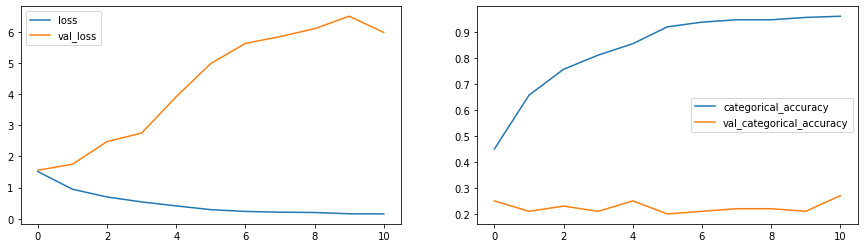

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)
plot(history_model1)

__Conclusion : The Model is Overfitting, as we have a very high Validation loss and a very low Validation Accuracy.__

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
conv_3d2=ModelConv3D1(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

Total Params: 3638981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7016 - categorical_accuracy: 0.4457  
Epoch 00001: val_loss improved from inf to 2.29724, saving model to model_init_2021-12-2803_36_42.107306/model-00001-1.70157-0.44570-2.29724-0.32000.h5
34/34 [==============================] - 5483s 166s/step - loss: 1.7016 - categorical_accuracy: 0.4457 - val_loss: 2.2972 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3517 - categorical_accuracy: 0.5339
Epoch 00002: val_loss did not improve from 2.29724
34/34 [==============================] - 207s 6s/step - loss: 1.3517 - categorical_accuracy: 0.5339 - val_loss: 3.5050 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0262 - categorical_accuracy: 0.6003
Epoch 00003: val_loss did not improve from 2.29724
34/34 [==============================] - 205s 6s/step - loss: 1.0262 - categorical_accura

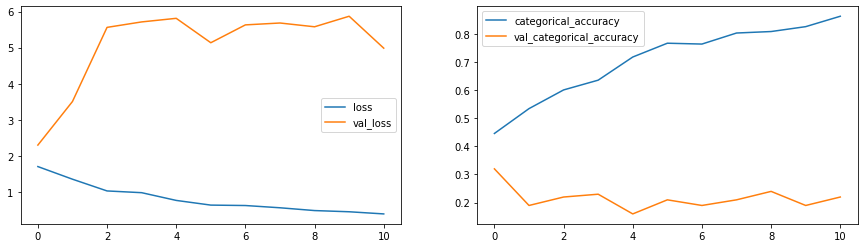

In [18]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)
plot(history_model2)

__Conclusion :  The Validation loss has not improved so early stopping the epoch automactically. The Validation Accuracy is has also not improved from the last run__

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [19]:
class ModelConv3D3(ModelProducer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d3=ModelConv3D3(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

Total Params: 1762613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.2890 - categorical_accuracy: 0.3122  
Epoch 00001: val_loss improved from inf to 1.95456, saving model to model_init_2021-12-2805_44_48.484984/model-00001-2.28903-0.31222-1.95456-0.16000.h5
23/23 [==============================] - 1515s 69s/step - loss: 2.2890 - categorical_accuracy: 0.3122 - val_loss: 1.9546 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5279 - categorical_accuracy: 0.4872
Epoch 00002: val_loss did not improve from 1.95456
23/23 [==============================] - 147s 7s/step - loss: 1.5279 - categorical_accuracy: 0.4872 - val_loss: 3.5136 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2869 - categorical_accuracy: 0.5558
Epoch 00003: val_loss did not improve from 1.95456
23/23 [==============================] - 147s 7s/step - loss: 1.2869 - categorical

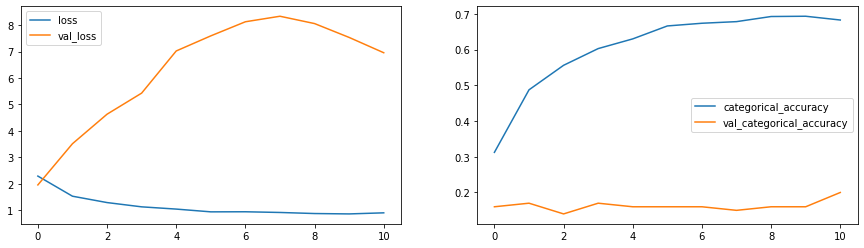

In [21]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)
plot(history_model3)


__Conclusion : No imporvement is seen in the Validation loss and Validation Accuracy__

# Model 4 - Adding more layers

In [22]:
class ModelConv3D4(ModelProducer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d4=ModelConv3D4(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

Total Params: 2556533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9127 - categorical_accuracy: 0.3816
Epoch 00001: val_loss improved from inf to 1.63677, saving model to model_init_2021-12-2806_35_32.024715/model-00001-1.91267-0.38160-1.63677-0.24000.h5
34/34 [==============================] - 152s 4s/step - loss: 1.9127 - categorical_accuracy: 0.3816 - val_loss: 1.6368 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4580 - categorical_accuracy: 0.5264
Epoch 00002: val_loss did not improve from 1.63677
34/34 [==============================] - 149s 4s/step - loss: 1.4580 - categorical_accuracy: 0.5264 - val_loss: 2.1840 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4689 - categorical_accuracy: 0.4977
Epoch 00003: val_loss did not improve from 1.63677
34/34 [==============================] - 148s 4s/step - loss: 1.4689 - categorical_accuracy: 0

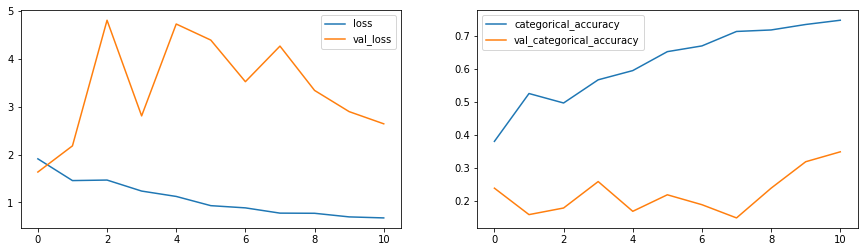

In [24]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)
plot(history_model4)

__Conclusion : With More layers we dont see much performance improvement in the Validation loss and Validation accuracy__

# Model 5 Adding dropout at convolution layers

In [25]:
class ModelConv3D5(ModelProducer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_3d5=ModelConv3D5(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

Total Params: 2556533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.6716 - categorical_accuracy: 0.3884
Epoch 00001: val_loss improved from inf to 2.27789, saving model to model_init_2021-12-2807_03_01.589592/model-00001-1.67161-0.38839-2.27789-0.19000.h5
34/34 [==============================] - 158s 5s/step - loss: 1.6716 - categorical_accuracy: 0.3884 - val_loss: 2.2779 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.3139 - categorical_accuracy: 0.5226
Epoch 00002: val_loss did not improve from 2.27789
34/34 [==============================] - 150s 5s/step - loss: 1.3139 - categorical_accuracy: 0.5226 - val_loss: 2.7347 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.0908 - categorical_accuracy: 0.5671
Epoch 00003: val_loss did not improve from 2.27789
34/34 [==============================] - 154s 5s/step - loss: 1.0908 - categorical_accuracy: 0

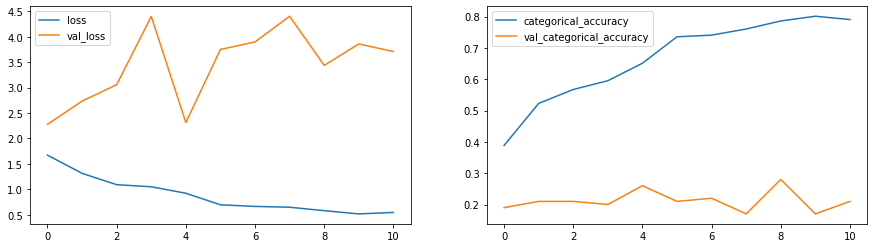

In [27]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)
plot(history_model5)


__Conclusion : Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

# Model 6 - reducing the number of parameters

In [28]:
class ModelConv3D6(ModelProducer):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv_3d6=ModelConv3D6(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 8, 50, 50, 32)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 696645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7721 - categorical_accuracy: 0.3816
Epoch 00001: val_loss improved from inf to 1.93190, saving model to model_init_2021-12-2807_30_59.271450/model-00001-1.77208-0.38160-1.93190-0.21000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.7721 - categorical_accuracy: 0.3816 - val_loss: 1.9319 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1062 - categorical_accuracy: 0.5777
Epoch 00002: val_loss did not improve from 1.93190
34/34 [==============================] - 146s 4s/step - loss: 1.1062 - categorical_accuracy: 0.5777 - val_loss: 2.8824 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9216 - categorical_accuracy: 0.6569
Epoch 00003: val_loss did not improve from 1.93190
34/34 [==============================] - 147s 4s/step - loss: 0.9216 - categorical_acc

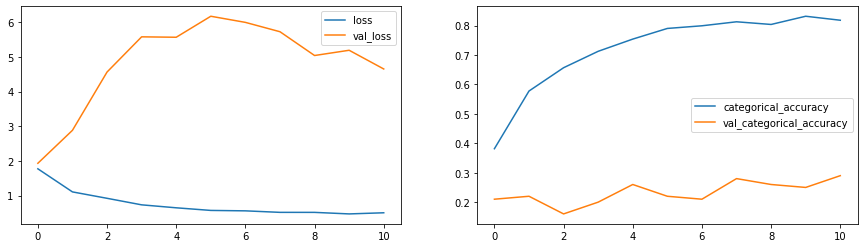

In [30]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)
plot(history_model6)


__Conclusion : Recuding the parameters did not help in getting a good validation loss and validation accuracy__

# Model 7 - reducing the number of parameters further

In [31]:
class ModelConv3D7(ModelProducer):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
conv_3d7=ModelConv3D7(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_50 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_37 (Activation)  (None, 8, 60, 60, 32)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 504709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7777 - categorical_accuracy: 0.3492
Epoch 00001: val_loss improved from inf to 2.30810, saving model to model_init_2021-12-2807_57_49.368033/model-00001-1.77769-0.34917-2.30810-0.16000.h5
34/34 [==============================] - 151s 5s/step - loss: 1.7777 - categorical_accuracy: 0.3492 - val_loss: 2.3081 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3177 - categorical_accuracy: 0.5113
Epoch 00002: val_loss did not improve from 2.30810
34/34 [==============================] - 150s 5s/step - loss: 1.3177 - categorical_accuracy: 0.5113 - val_loss: 3.2430 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1233 - categorical_accuracy: 0.5679
Epoch 00003: val_loss did not improve from 2.30810
34/34 [==============================] - 147s 4s/step - loss: 1.1233 - categorical_acc

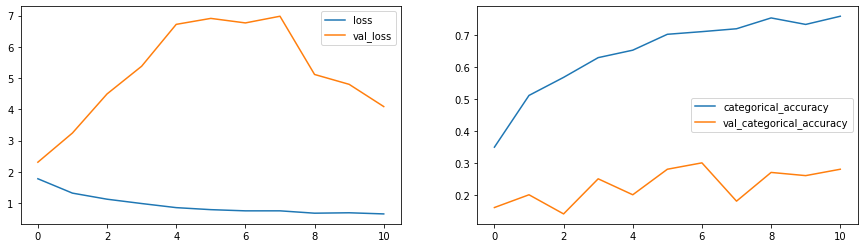

In [33]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)
plot(history_model7)

__Conclusion : Further reducing the parameters has imporved the Validation loss and Validation Accuracy from the previous run__

# Model 8 - reducing the number of parameters

In [34]:
class ModelConv3D8(ModelProducer):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d8=ModelConv3D8(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_56 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_41 (Activation)  (None, 8, 60, 60, 16)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 230949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9301 - categorical_accuracy: 0.2911
Epoch 00001: val_loss improved from inf to 1.74477, saving model to model_init_2021-12-2808_25_12.956416/model-00001-1.93007-0.29110-1.74477-0.21000.h5
34/34 [==============================] - 153s 5s/step - loss: 1.9301 - categorical_accuracy: 0.2911 - val_loss: 1.7448 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4088 - categorical_accuracy: 0.4578
Epoch 00002: val_loss did not improve from 1.74477
34/34 [==============================] - 148s 4s/step - loss: 1.4088 - categorical_accuracy: 0.4578 - val_loss: 2.2766 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2784 - categorical_accuracy: 0.4970
Epoch 00003: val_loss did not improve from 1.74477
34/34 [==============================] - 148s 4s/step - loss: 1.2784 - categorical_acc

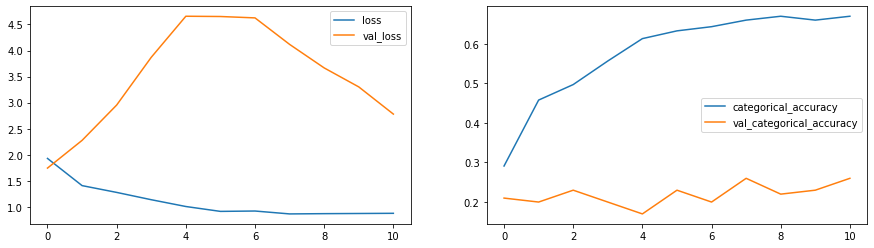

In [36]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)
plot(history_model8)

__Conclusion : The Validation loss and Validation accuracy are almost simiilar from the previous run and did not see any more improvement from the last run__

# Model 9 - CNN- LSTM Model

In [37]:
class RNNCNN1(ModelProducer):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
rnn_cnn1=RNNCNN1(train_file,val_file,train_folder,val_folder,no_of_classes)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

Total Params: 1657445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4229 - categorical_accuracy: 0.4050 
Epoch 00001: val_loss improved from inf to 1.70885, saving model to model_init_2021-12-2808_52_38.897916/model-00001-1.42286-0.40498-1.70885-0.16000.h5
34/34 [==============================] - 868s 26s/step - loss: 1.4229 - categorical_accuracy: 0.4050 - val_loss: 1.7088 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1139 - categorical_accuracy: 0.5407
Epoch 00002: val_loss did not improve from 1.70885
34/34 [==============================] - 167s 5s/step - loss: 1.1139 - categorical_accuracy: 0.5407 - val_loss: 1.9957 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8867 - categorical_accuracy: 0.6516
Epoch 00003: val_loss did not improve from 1.70885
34/34 [==============================] - 167s 5s/step - loss: 0.8867 - categorical_accuracy:

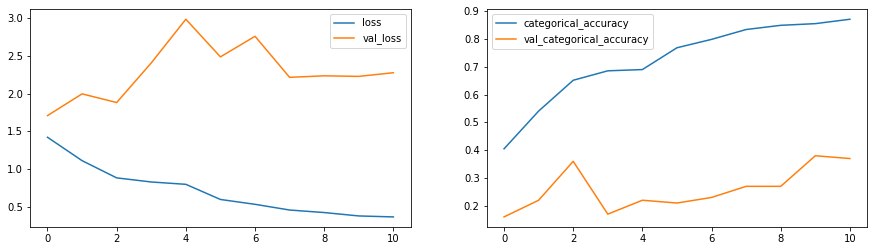

In [39]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)
plot(history_model9)

__Conclusion: The model is again overfitting with very high Validation loss and low Validation accuracy__

### Let's apply some data augmentation & check the model performance.

In [40]:
class ModelProducerMoreAugmentation():
    
    def __init__(self,train_file,val_file,train_folder,val_folder,no_of_classes):
        '''
        train_file : path to the training file along with filename.
        val_file : path to the validation file along with filename.
        train_folder : path to training videos / frames
        val_folder : patht to validation videos / frames
        '''
        self.train_doc = np.random.permutation(open(train_file).readlines())
        self.val_doc = np.random.permutation(open(val_file).readlines())
        self.train_path = train_folder
        self.val_path =  val_folder
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.num_classes=no_of_classes
        
        
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100,no_of_channels=3,no_of_frames=30):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=no_of_channels
        self.total_frames=no_of_frames
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # The generator function 
    
    def generator(self,source_path, folder_list,augment=False):
        
        # We will try frames_to_sample in order to check the execution time and accuracy.
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        
        
        batch_size=self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
            
            # Check if any data points are pending to be processed.
            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    # Create a function to get one batch of data.
    def get_one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    # Crearte abstract method to be overloaded by child class to define the model.
    @abc.abstractmethod
    def define_model(self):
        pass

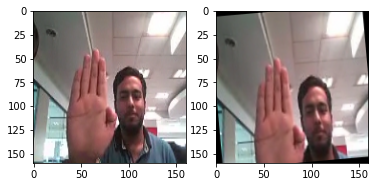

In [41]:
test_generator=ModelProducerMoreAugmentation(train_file,val_file,train_folder,val_folder,no_of_classes)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 10 with Augmentation

### (3,3,3) Filter & 160 x 160 Image resolution - similar with Model 2

In [42]:
class ModelConv3D10(ModelProducerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [43]:
conv_3d10=ModelConv3D10(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_67 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_45 (Activation)  (None, 10, 80, 80, 32)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 3638981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0033 - categorical_accuracy: 0.3492
Epoch 00001: val_loss improved from inf to 2.13703, saving model to model_init_2021-12-2809_35_46.444238/model-00001-2.00335-0.34917-2.13703-0.21000.h5
34/34 [==============================] - 217s 7s/step - loss: 2.0033 - categorical_accuracy: 0.3492 - val_loss: 2.1370 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4456 - categorical_accuracy: 0.5030
Epoch 00002: val_loss did not improve from 2.13703
34/34 [==============================] - 217s 7s/step - loss: 1.4456 - categorical_accuracy: 0.5030 - val_loss: 3.2310 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2341 - categorical_accuracy: 0.5656
Epoch 00003: val_loss did not improve from 2.13703
34/34 [==============================] - 215s 7s/step - loss: 1.2341 - categorical_acc

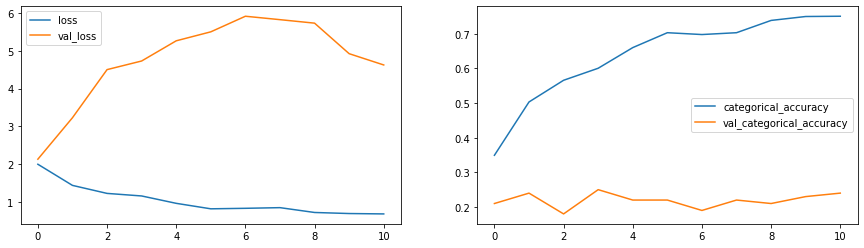

In [44]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)
plot(history_model10)

## Model 11 with Augmentation

### (2,2,2) Filter & 120 x 120 Image resolution - similar to Model 3

In [45]:
class ModelConv3D11(ModelProducerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [46]:
conv_3d11=ModelConv3D11(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_73 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_49 (Activation)  (None, 8, 60, 60, 32)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 1762613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0503 - categorical_accuracy: 0.3326
Epoch 00001: val_loss improved from inf to 1.86732, saving model to model_init_2021-12-2810_15_42.948041/model-00001-2.05026-0.33258-1.86732-0.16000.h5
23/23 [==============================] - 164s 7s/step - loss: 2.0503 - categorical_accuracy: 0.3326 - val_loss: 1.8673 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5669 - categorical_accuracy: 0.4615
Epoch 00002: val_loss did not improve from 1.86732
23/23 [==============================] - 155s 7s/step - loss: 1.5669 - categorical_accuracy: 0.4615 - val_loss: 2.6639 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3252 - categorical_accuracy: 0.5256
Epoch 00003: val_loss did not improve from 1.86732
23/23 [==============================] - 154s 7s/step - loss: 1.3252 - categorical_acc

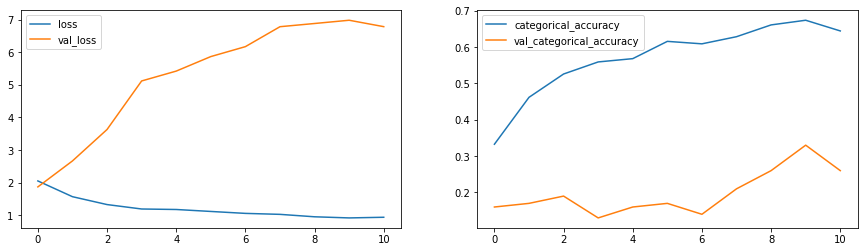

In [47]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)
plot(history_model11)

## Model 12 with Augmentation

### Adding more layers = Similar to model 4

In [48]:
class ModelConv3D12(ModelProducerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
conv_3d12=ModelConv3D12(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_79 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_80 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 2556533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.2431 - categorical_accuracy: 0.3145
Epoch 00001: val_loss improved from inf to 1.97370, saving model to model_init_2021-12-2810_44_20.834334/model-00001-2.24310-0.31448-1.97370-0.21000.h5
34/34 [==============================] - 158s 5s/step - loss: 2.2431 - categorical_accuracy: 0.3145 - val_loss: 1.9737 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.4555
Epoch 00002: val_loss did not improve from 1.97370
34/34 [==============================] - 156s 5s/step - loss: 1.6046 - categorical_accuracy: 0.4555 - val_loss: 3.0467 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3730 - categorical_accuracy: 0.5098
Epoch 00003: val_loss did not improve from 1.97370
34/34 [==============================] - 154s 5s/step - loss: 1.3730 - categorical_acc

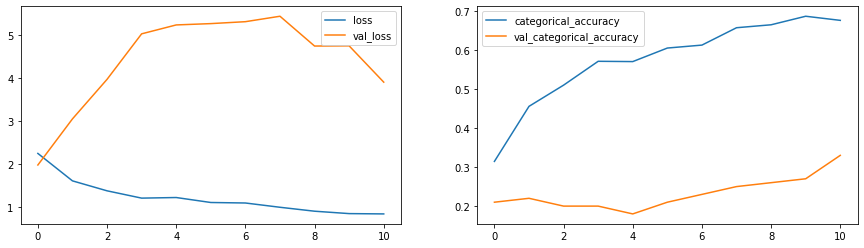

In [50]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)
plot(history_model12)

## Model 13 with Augmentation

### Adding Dropouts - Similar to ModeL 5

In [51]:
class ModelConv3D13(ModelProducerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d13=ModelConv3D13(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_89 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_61 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_61 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 2556533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8737 - categorical_accuracy: 0.3296
Epoch 00001: val_loss improved from inf to 2.01447, saving model to model_init_2021-12-2811_12_52.652514/model-00001-1.87370-0.32956-2.01447-0.16000.h5
34/34 [==============================] - 158s 5s/step - loss: 1.8737 - categorical_accuracy: 0.3296 - val_loss: 2.0145 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5587 - categorical_accuracy: 0.4163
Epoch 00002: val_loss did not improve from 2.01447
34/34 [==============================] - 155s 5s/step - loss: 1.5587 - categorical_accuracy: 0.4163 - val_loss: 2.6803 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3260 - categorical_accuracy: 0.5008
Epoch 00003: val_loss did not improve from 2.01447
34/34 [==============================] - 157s 5s/step - loss: 1.3260 - categorical_acc

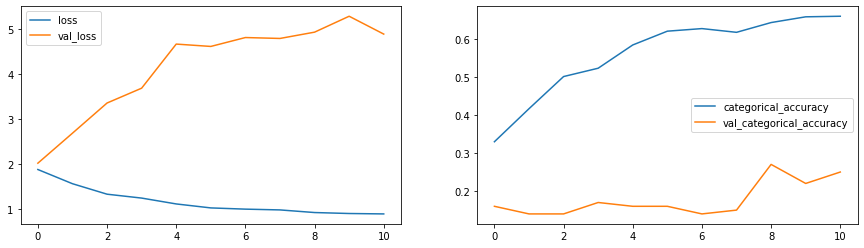

In [53]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)
plot(history_model13)

## Model 14 with Augmentation

### Reducing network parameters - Similar to Model 6

In [54]:
class ModelConv3D14(ModelProducerMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [55]:
conv_3d14=ModelConv3D14(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_99 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 50, 50, 32)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 696645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7995 - categorical_accuracy: 0.3612
Epoch 00001: val_loss improved from inf to 2.01859, saving model to model_init_2021-12-2811_41_41.125785/model-00001-1.79947-0.36124-2.01859-0.16000.h5
34/34 [==============================] - 152s 5s/step - loss: 1.7995 - categorical_accuracy: 0.3612 - val_loss: 2.0186 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2205 - categorical_accuracy: 0.5347
Epoch 00002: val_loss did not improve from 2.01859
34/34 [==============================] - 151s 5s/step - loss: 1.2205 - categorical_accuracy: 0.5347 - val_loss: 2.9367 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9589 - categorical_accuracy: 0.6403
Epoch 00003: val_loss did not improve from 2.01859
34/34 [==============================] - 151s 5s/step - loss: 0.9589 - categorical_acc

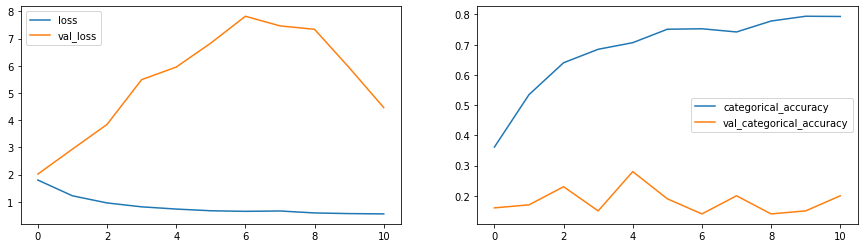

In [56]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)
plot(history_model14)

## Model 15 with Augmentation

### Reducing network parameters again - Similar to Model 7

In [57]:
class ModelConv3D15(ModelProducerMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [58]:
conv_3d15=ModelConv3D15(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_105 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_73 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_73 (Activation)  (None, 8, 60, 60, 32)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 504709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8532 - categorical_accuracy: 0.3175
Epoch 00001: val_loss improved from inf to 1.80733, saving model to model_init_2021-12-2812_09_40.244962/model-00001-1.85319-0.31750-1.80733-0.19000.h5
34/34 [==============================] - 157s 5s/step - loss: 1.8532 - categorical_accuracy: 0.3175 - val_loss: 1.8073 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2745 - categorical_accuracy: 0.5211
Epoch 00002: val_loss did not improve from 1.80733
34/34 [==============================] - 154s 5s/step - loss: 1.2745 - categorical_accuracy: 0.5211 - val_loss: 2.4045 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0768 - categorical_accuracy: 0.5860
Epoch 00003: val_loss did not improve from 1.80733
34/34 [==============================] - 156s 5s/step - loss: 1.0768 - categorical_acc

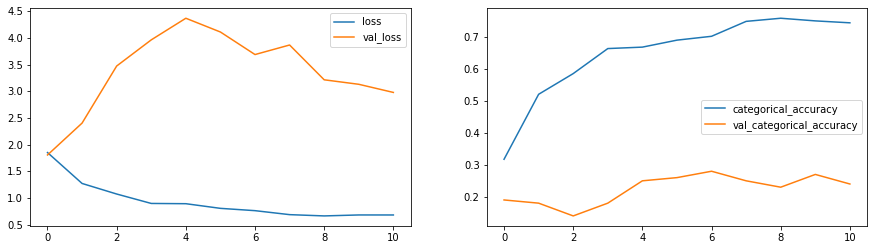

In [59]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)
plot(history_model15)

## Model 16 with Augmentation

### CNN LSTM with GRU - Similar to ModeL 8

In [60]:
class ModelConv3D16(ModelProducerMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
conv_3d16=ModelConv3D16(train_file,val_file,train_folder,val_folder,no_of_classes)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)

conv_3d16_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_111 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_77 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_77 (Activation)  (None, 8, 60, 60, 16)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 230949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1130 - categorical_accuracy: 0.2617
Epoch 00001: val_loss improved from inf to 1.69419, saving model to model_init_2021-12-2814_53_24.340428/model-00001-2.11300-0.26169-1.69419-0.16000.h5
34/34 [==============================] - 153s 5s/step - loss: 2.1130 - categorical_accuracy: 0.2617 - val_loss: 1.6942 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5795 - categorical_accuracy: 0.4208
Epoch 00002: val_loss did not improve from 1.69419
34/34 [==============================] - 150s 5s/step - loss: 1.5795 - categorical_accuracy: 0.4208 - val_loss: 2.0879 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3348 - categorical_accuracy: 0.4940
Epoch 00003: val_loss did not improve from 1.69419
34/34 [==============================] - 155s 5s/step - loss: 1.3348 - categorical_acc

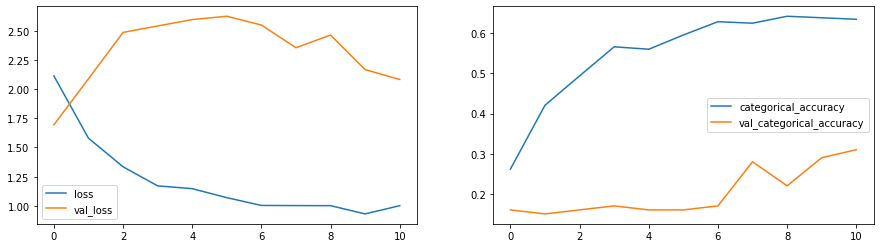

In [75]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)
plot(history_model16)


## Model 17 - CNN LSTM WITH GRU - Similar to Model 9


### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

In [63]:
class RNNCNN2(ModelProducerMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [64]:
rnn_cnn2=RNNCNN2(train_file,val_file,train_folder,val_folder,no_of_classes)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total Params: 2573925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4063 - categorical_accuracy: 0.4110
Epoch 00001: val_loss improved from inf to 1.80453, saving model to model_init_2021-12-2812_39_42.788457/model-00001-1.40627-0.41101-1.80453-0.21000.h5
34/34 [==============================] - 175s 5s/step - loss: 1.4063 - categorical_accuracy: 0.4110 - val_loss: 1.8045 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0214 - categorical_accuracy: 0.5913
Epoch 00002: val_loss did not improve from 1.80453
34/34 [==============================] - 172s 5s/step - loss: 1.0214 - categorical_accuracy: 0.5913 - val_loss: 2.1896 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8575 - categorical_accuracy: 0.6546
Epoch 00003: val_loss did not improve from 1.80453
34/34 [==============================] - 172s 5s/step - loss: 0.8575 - categorical_acc

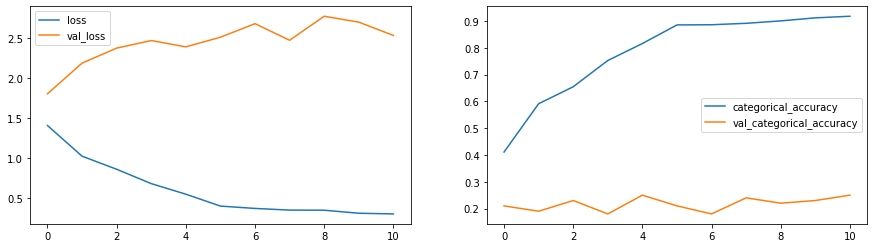

In [65]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)
plot(history_model17)

## Model 18 - Transfer Learning

In [66]:
from keras.applications import mobilenet

In [67]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelProducerMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


17235968/17225924 [==============================] - 1s 0us/step


In [68]:
rnn_cnn_tl=RNNCNN_TL(train_file,val_file,train_folder,val_folder,no_of_classes)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

Total Params: 3840453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3703 - categorical_accuracy: 0.4133
Epoch 00001: val_loss improved from inf to 0.83326, saving model to model_init_2021-12-2813_11_08.406740/model-00001-1.37033-0.41327-0.83326-0.73000.h5
133/133 [==============================] - 161s 1s/step - loss: 1.3703 - categorical_accuracy: 0.4133 - val_loss: 0.8333 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8784 - categorical_accuracy: 0.6606
Epoch 00002: val_loss improved from 0.83326 to 0.80432, saving model to model_init_2021-12-2813_11_08.406740/model-00002-0.87840-0.66063-0.80432-0.68000.h5
133/133 [==============================] - 157s 1s/step - loss: 0.8784 - categorical_accuracy: 0.6606 - val_loss: 0.8043 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7881 - categorical_accuracy: 0.6968
Epoch 00003: val_loss improved

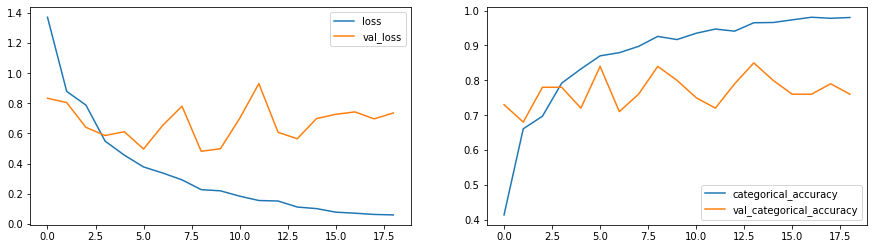

In [69]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)
plot(history_model18)

__Great Results so far, the model has given us Validation Accuracy of 76% the test so far__

## Model - 19 - Transfer Learning with GRU and traning all weights

In [74]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelProducerMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [73]:
rnn_cnn_tl2=RNNCNN_TL2(train_file,val_file,train_folder,val_folder,no_of_classes)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)             

Total Params: 3693253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1104 - categorical_accuracy: 0.5551
Epoch 00001: val_loss improved from inf to 1.15952, saving model to model_init_2021-12-2814_00_59.922746/model-00001-1.11038-0.55505-1.15952-0.54000.h5
133/133 [==============================] - 167s 1s/step - loss: 1.1104 - categorical_accuracy: 0.5551 - val_loss: 1.1595 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6517 - categorical_accuracy: 0.7466
Epoch 00002: val_loss improved from 1.15952 to 0.45534, saving model to model_init_2021-12-2814_00_59.922746/model-00002-0.65172-0.74661-0.45534-0.80000.h5
133/133 [==============================] - 156s 1s/step - loss: 0.6517 - categorical_accuracy: 0.7466 - val_loss: 0.4553 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5270 - categorical_accuracy: 0.8092
Epoch 00003: val_loss improved

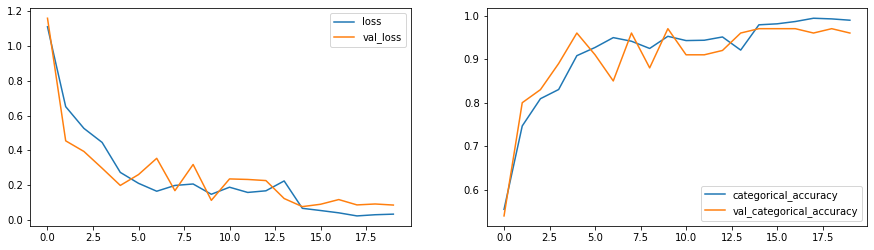

In [72]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)
plot(history_model19)